## Abstract
This post explores Newton's Method for Logistic Regression. I used previous code for creating a linear model and using logistic regression to implement a Newton's Optimizer class. This class uses the Hessian matrix and gradient of the loss to find the minimal empirical risk of the model. I tested the Newton optimizer in comparison to the gradient descent optimizer, proving that the Newton optimizer converges to the same value as the gradient descent optimizer (and can converge faster than the gradient descent optimizer in some circumstances). I calculated the computational cost of both the Newton optimizer and the gradient descent optimizer and compared the costs of each. 

In [103]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer
from NewtonOptimizer import LogisticRegression, NewtonOptimizer
import torch
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part A: Implementing Newton's Optimizer

Source code of my implementation of Newton's Optimizer: https://github.com/tristanmeyer2/tristanmeyer2.github.io/blob/main/posts/NewtMethodLogReg/NewtonOptimizer.py

## Part B: Perform Experiments

In [104]:
def plot_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix]*2-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

def converge_loop_grad(LR, opt, X, y, maxIter, alpha, beta): 
    loss = 1
    loss_vec = []
    maxIterations = maxIter
    currIteration = 0

    while loss > 0 and currIteration < maxIterations:
        loss = LR.loss(X, y) 
        loss_vec.append(loss)
        opt.step(X, y, alpha = alpha, beta = beta)
        currIteration += 1

    return loss_vec

def converge_loop_newt(LR, opt, X, y, maxIter, alpha): 
    loss = 1
    loss_vec = []
    maxIterations = maxIter
    currIteration = 0

    while loss > 0 and currIteration < maxIterations:
        loss = LR.loss(X, y) 
        loss_vec.append(loss)
        opt.step(X, y, alpha = alpha)
        currIteration += 1

    return loss_vec

Defining three methods: plotting data, drawing a line on a visualization, creating data.
The plot_data() function plots two dimensional data on a scatter plot
The draw_line() function draws a "separating" line that maximizes classification accuracy on two dimensional data.  
The converge_loop_grad() function uses the logistic regression class and a gradient descent optimizer to find the minimal empirical risk. 
The converge_loop_newt() function uses the logistic regression class and a Newton's Method optimizer to find the minimal empirical risk. 

In [105]:
torch.manual_seed(1234)

X, y = classification_data(noise = 0.5)

Generating data points. 

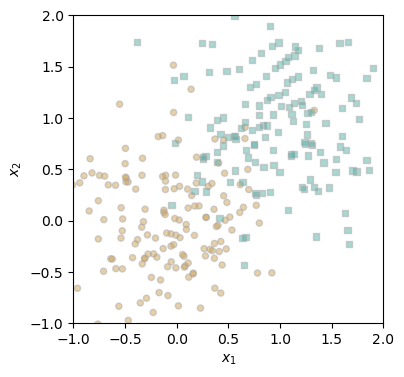

In [106]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_data(X, y, ax)

Visualizing the data points.

## Gradient Descent Performance 

In [107]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec_grad = converge_loop_grad(LR, opt, X, y, 100, 0.2, 0.9)

Minimizing empirical risk using the gradient descent optimizer class and using $\alpha$ = 0.2 and $\beta$ = 0.9

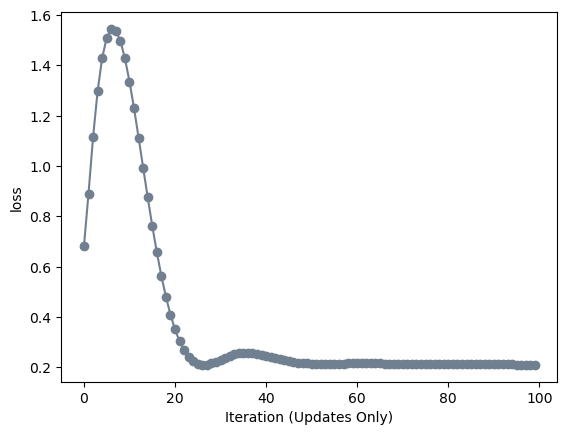

In [108]:
plt.plot(loss_vec_grad, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_grad)), loss_vec_grad, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "loss")

This plot shows the loss over 100 iterations. As shown, the loss decreases to around 0.2; therefore, in order to ensure my implementation of Newton's Method is working properly, it should reach a loss of around 0.2, as well.

## Newton's Method Performance

In [109]:
LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

loss_vec_newt = converge_loop_newt(LR, opt, X, y, 100, 20)

Minimizing empirical risk using the Newton's Method optimizer class and using $\alpha$ = 20. 

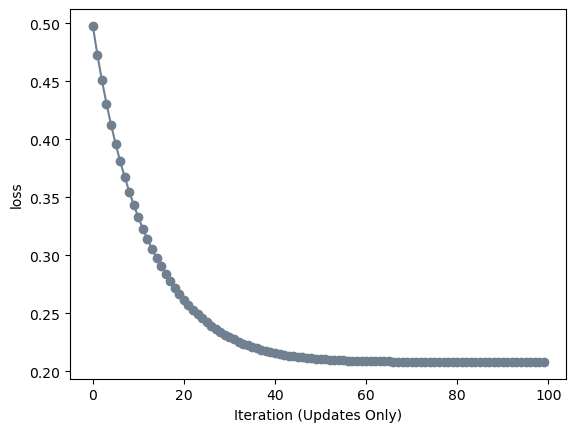

In [110]:
plt.plot(loss_vec_newt, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_newt)), loss_vec_newt, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "loss")

As shown by the plot, the loss decreases to around 0.2 using Newton's Method. 

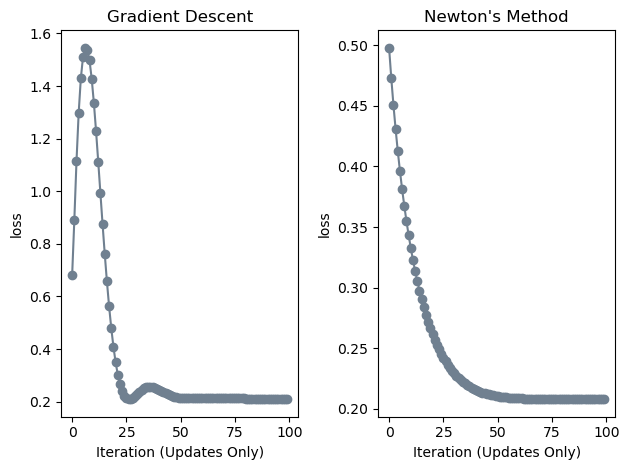

In [111]:
plt.subplot(1, 2, 1)
plt.plot(loss_vec_grad, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_grad)), loss_vec_grad, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "loss", title="Gradient Descent")

plt.subplot(1, 2, 2)
plt.plot(loss_vec_newt, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_newt)), loss_vec_newt, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "loss", title="Newton's Method")

plt.tight_layout()

As shown by the comparison between gradient descent and Newton's method, both optimizers converge to a loss of around 0.2. 

## Newton's Method Converging Faster than Gradient Descent

In [112]:
LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

loss_vec_newt = converge_loop_newt(LR, opt, X, y, 50, 300)

If the $\alpha$ value is increased in our step() function, the optimizer will converge faster. For this experiment, I used $\alpha$ = 300. 

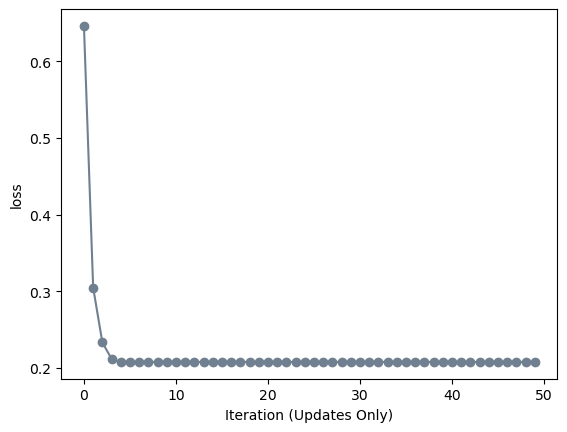

In [113]:
plt.plot(loss_vec_newt, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_newt)), loss_vec_newt, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "loss")

As seen by the plot, the optimizer converged in around 4 iterations. 

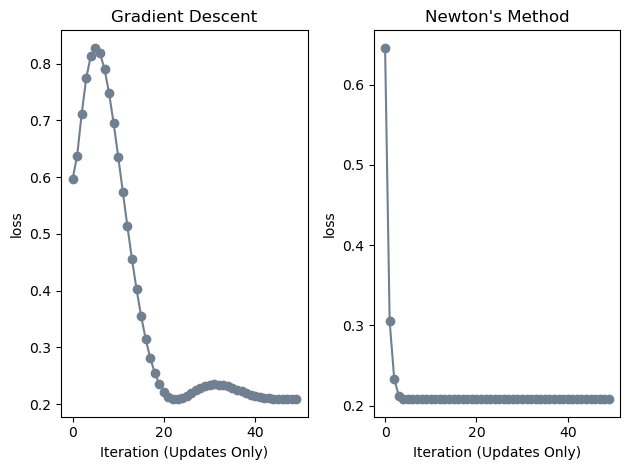

In [114]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec_grad = converge_loop_grad(LR, opt, X, y, 50, 0.2, 0.9)

plt.subplot(1, 2, 1)
plt.plot(loss_vec_grad, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_grad)), loss_vec_grad, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "loss", title="Gradient Descent")

plt.subplot(1, 2, 2)
plt.plot(loss_vec_newt, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_newt)), loss_vec_newt, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "loss", title="Newton's Method")

plt.tight_layout()

As shown by the comparison of the charts, Newton's method can converge faster than spicy gradient descent. 

## Newton's Method Failing to Converge

In [115]:
LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

loss_vec_newt = converge_loop_newt(LR, opt, X, y, 100, 601)

Using $\alpha$ = 601 as a learning rate for Newton's method. 

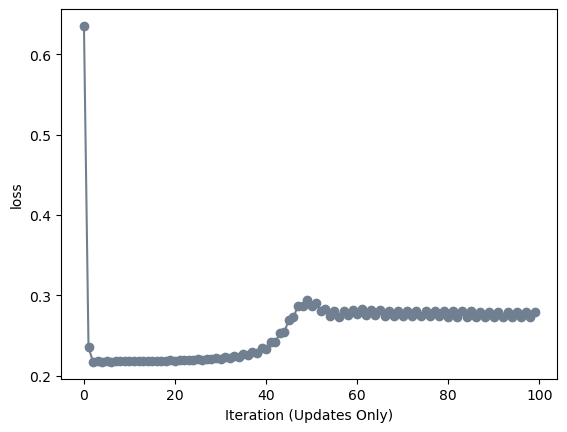

In [116]:
plt.plot(loss_vec_newt, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_newt)), loss_vec_newt, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "loss")

As shown in the graph of the loss through 100 iterations, Newton's method fails to converge at a loss of 0.2 and instead begins to increase at around 30 iterations and seems to converge around 0.3 over 100 iterations. Therefore, using $\alpha$ = 601, Newton's method does not perform correctly. 

## Part C: Operation Counting

Given the following computational times: 

Loss = $c$

Gradient = $2c$

Hessian = $pc$

Inverting a pxp matrix = $k_{1}p^{\gamma}$

Matrix-Vector multiplication = $k_{2}p^{2}$

Given Newton's Method converges in $t_{nm}$ steps and gradient descent converges in $t_{gd}$ steps

Computational Cost of Gradient Descent = $t_{gd}(2c)+c$

Computational Cost of Newton's Method = $t_{nm}(2c+pc+k_{1}p^{\gamma}+k_{2}p^{2})+c$

Computing how much smaller $t_{nm}$ must be than $t_{gd}$ to ensure Newton's Method will require fewer computational units to complete:

$$t_{nm}(2c+pc+k_{1}p^{\gamma}+k_{2}p^{2})+c < t_{gd}(2c)+c$$
$$t_{nm}(2c+pc+k_{1}p^{\gamma}+k_{2}p^{2}) < t_{gd}(2c)$$
$$t_{nm}(1+\frac{p}{2}+\frac{k_{1}p^{\gamma}}{2c}+\frac{k_{2}p^{2}}{2c}) < t_{gd}$$

This inequality shows that in order for Newton's method to have a smaller computational cost that gradient descent, $t_{nm}$ have to be smaller than $t_{gd}$ by a factor of $(1+\frac{p}{2}+\frac{k_{1}p^{\gamma}}{2c}+\frac{k_{2}p^{2}}{2c})$

Further, when the number of features, p, becomes large, it's unlikely that Newton's Method will ever be computationally more efficient than gradient descent. 

## Conclusions
I successfully implemented Newton's Method for logistic regression and tested it under multiple circumstances. This post was great practice for implementing efficient mathematical equations in python. I also improved my ability to using pyplot to display my experience. This post was also a great refresher on calculating the computational cost of functions and comparing two costs. 